<a href="https://colab.research.google.com/github/Charles8745/gans-in-action/blob/master/gans_in_action_CH4_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

import sys
import matplotlib.pyplot as plt
import numpy as np
import keras

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape, LeakyReLU, Activation, BatchNormalization, Dropout, Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam


print(f"Pythyon: {sys.version}")
print(f"Keras: {keras.__version__}")

Pythyon: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Keras: 3.8.0


In [3]:
# Hyperparameters
img_height = 28
img_width = 28
channel = 1
z_dim = 100 # Noise的向量長度
iterations = 20000
batch_size = 128
sample_interval = 500

img_size = (img_width, img_height, channel)

In [4]:
# Build generator
def build_generator(img_size, z_dim):
  model = Sequential()

  model.add(keras.Input(shape=(z_dim,)))

  model.add(Dense(7*7*256))
  model.add(Reshape((7, 7, 256)))

  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

  model.add(BatchNormalization())

  model.add(LeakyReLU(negative_slope=0.01))

  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

  model.add(BatchNormalization())

  model.add(LeakyReLU(negative_slope=0.01))

  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

  model.add(Activation('tanh'))

  return model

In [52]:
# Build discriminator

# # 以下為原本上一章gan的D
# def build_discriminator(img_size):
#   model = Sequential()
#   model.add(keras.Input(shape=img_size))
#   model.add(Flatten())
#   model.add(Dense(128))
#   model.add(LeakyReLU(negative_slope=0.01))
#   model.add(Dense(1, activation='sigmoid')) # Sigmoid輸出[0,1]

#   return model

# 改良之後
def build_discriminator(img_size):
  model = Sequential()
  model.add(keras.Input(shape=img_size))

  model.add(Conv2D(16,kernel_size=4, strides=2, padding='same')) # 14,14,16

  model.add(LeakyReLU(negative_slope=0.01))

  model.add(Conv2D(32,kernel_size=4, strides=2, padding='same')) # 7,7,32

  model.add(LeakyReLU(negative_slope=0.01))

  model.add(Flatten())

  model.add(Dense(512))

  model.add(LeakyReLU(negative_slope=0.01))

  model.add(Dense(1, activation='sigmoid'))

  return model

# 以下為原本書上版本
# def build_discriminator(img_size):
#   model = Sequential()

#   model.add(keras.Input(shape=img_size))

#   model.add(Conv2D(32,kernel_size=2, strides=2, padding='same'))

#   model.add(LeakyReLU(negative_slope=0.01))

#   model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))

#   model.add(BatchNormalization())

#   model.add(LeakyReLU(negative_slope=0.01))

#   model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))

#   model.add(BatchNormalization())

#   model.add(LeakyReLU(negative_slope=0.01))

#   model.add(Flatten())

#   model.add(Dense(1, activation='sigmoid'))

#   return model


In [53]:
# Build Gan
def build_gan(generator, discriminator):
  model = Sequential()

  model.add(generator)
  model.add(discriminator)

  return model

In [54]:
# Compile: ge, D, G

# build ge
generator = build_generator(img_size, z_dim)

# compile D
discriminator = build_discriminator(img_size)
discriminator.compile(
    loss = 'binary_crossentropy', # 使用二元交叉熵，評估二元分類預測與實際的差距
    optimizer = Adam(),
    metrics = ['accuracy'])

# lock D when training generator
# discriminator.trainable = False # 書上這邊是錯的

# compile GAN
gan = build_gan(generator, discriminator)
gan.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    )


In [55]:
print("Generator Summary:")
generator.summary()

print("\nDiscriminator Summary:")
discriminator.summary()

print("\nGAN Summary:")
gan.summary()

Generator Summary:


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 12544)          │     1,266,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_30             │ (None, 14, 14, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_31             │ (None, 14, 14, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_32             │ (None, 28, 28, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,637,121 (6.25 MB)

 Trainable params: 1,636,737 (6.24 MB)

 Non-trainable params: 384 (1.50 KB)


Discriminator Summary:


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 16)     │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 7, 7, 32)       │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 512)            │       803,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_38 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812,337 (3.10 MB)

 Trainable params: 812,337 (3.10 MB)

 Non-trainable params: 0 (0.00 B)


GAN Summary:


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_27 (Sequential)      │ (None, 28, 28, 1)      │     1,637,121 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_28 (Sequential)      │ (None, 1)              │       812,337 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,449,458 (9.34 MB)

 Trainable params: 2,449,074 (9.34 MB)

 Non-trainable params: 384 (1.50 KB)

In [56]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
  # sample noise
  z = np.random.normal(0,1,(image_grid_rows*image_grid_columns, z_dim))

  # generate imgs
  gen_imgs = generator.predict(z, verbose=0)

  # rescale
  gen_imgs = 0.5 * gen_imgs + 0.5

  # Set grid
  fig, axs = plt.subplots(
      image_grid_rows,
      image_grid_columns,
      figsize = (4,4),
      sharey=True,
      sharex=True
      )

  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      # Output a grid of images
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

In [57]:
# 編寫訓練程式

# 紀錄訓練過程
losses = []
accuracies = []
iter_ckpt = []

def train(iters, batch_size, sample_interval):
  # load mnist data
  (x_train,_), (_,_) = mnist.load_data()

  # data preprocess
  x_train = x_train/127.5 - 1.0 # 因為使用tanh
  x_train = np.expand_dims(x_train, axis=3)
  '''
  The original MNIST images are grayscale and have dimensions (number of images, height, width)
  . This line adds a channel dimension, making the shape (number of images, height, width, 1).
  '''

  real = np.ones((batch_size, 1)) # label
  fake = np.zeros((batch_size, 1))

  # train loop
  for iter in range(iters):
    '''
    Training D
    '''
    discriminator.trainable = True
    # get some real imgs
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx]

    # generate some fake imgs
    z = np.random.normal(0,1, (batch_size,z_dim))
    gen_imgs = generator.predict(z, verbose=0)

    # train D
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    '''
    Training G
    '''
    discriminator.trainable = False # 要記得鎖discriminator
    # train GAN
    z = np.random.normal(0,1,(batch_size, z_dim))
    g_loss = gan.train_on_batch(z, real) # 訓練Generator時要讓圖的label接近1

    # sample
    if (iter+1) % sample_interval == 0:
      # save losses, accuracies, ckpt
      losses.append((d_loss, g_loss))
      accuracies.append(100.0*accuracy)
      iter_ckpt.append(iter+1)

      # print progress
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
        (iter + 1, d_loss, 100.0 * accuracy, g_loss))

      # sample fake img
      sample_images(generator)

500 [D loss: 0.187634, acc.: 92.86%] [G loss: 2.446607]
1000 [D loss: 0.194361, acc.: 92.39%] [G loss: 2.962889]
1500 [D loss: 0.219838, acc.: 91.19%] [G loss: 2.959945]
2000 [D loss: 0.236977, acc.: 90.39%] [G loss: 2.906279]
2500 [D loss: 0.247830, acc.: 89.87%] [G loss: 2.865924]
3000 [D loss: 0.255886, acc.: 89.45%] [G loss: 2.836525]
3500 [D loss: 0.261779, acc.: 89.15%] [G loss: 2.815018]
4000 [D loss: 0.267341, acc.: 88.83%] [G loss: 2.783235]
4500 [D loss: 0.271145, acc.: 88.61%] [G loss: 2.755558]
5000 [D loss: 0.274280, acc.: 88.42%] [G loss: 2.730352]
5500 [D loss: 0.276596, acc.: 88.27%] [G loss: 2.709427]
6000 [D loss: 0.278695, acc.: 88.13%] [G loss: 2.687825]
6500 [D loss: 0.281035, acc.: 87.97%] [G loss: 2.663609]
7000 [D loss: 0.282391, acc.: 87.87%] [G loss: 2.643533]
7500 [D loss: 0.282619, acc.: 87.83%] [G loss: 2.635373]
8000 [D loss: 0.282871, acc.: 87.80%] [G loss: 2.626022]
8500 [D loss: 0.283004, acc.: 87.78%] [G loss: 2.618122]
9000 [D loss: 0.282538, acc.: 87

/tmp/ipython-input-56-2329355593.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(


11000 [D loss: 0.279306, acc.: 87.90%] [G loss: 2.618994]
11500 [D loss: 0.277801, acc.: 87.97%] [G loss: 2.624436]
12000 [D loss: 0.276147, acc.: 88.05%] [G loss: 2.632143]
12500 [D loss: 0.274423, acc.: 88.13%] [G loss: 2.641261]
13000 [D loss: 0.272284, acc.: 88.24%] [G loss: 2.658076]
13500 [D loss: 0.270017, acc.: 88.35%] [G loss: 2.678418]
14000 [D loss: 0.267878, acc.: 88.45%] [G loss: 2.695289]
14500 [D loss: 0.265752, acc.: 88.55%] [G loss: 2.711559]
15000 [D loss: 0.263471, acc.: 88.66%] [G loss: 2.730217]
15500 [D loss: 0.261022, acc.: 88.77%] [G loss: 2.751607]
16000 [D loss: 0.258611, acc.: 88.89%] [G loss: 2.772720]
16500 [D loss: 0.256064, acc.: 89.01%] [G loss: 2.795836]
17000 [D loss: 0.253473, acc.: 89.13%] [G loss: 2.819314]
17500 [D loss: 0.250768, acc.: 89.26%] [G loss: 2.846565]
18000 [D loss: 0.248084, acc.: 89.38%] [G loss: 2.872283]
18500 [D loss: 0.245394, acc.: 89.51%] [G loss: 2.900980]
19000 [D loss: 0.242702, acc.: 89.64%] [G loss: 2.928866]
19500 [D loss:

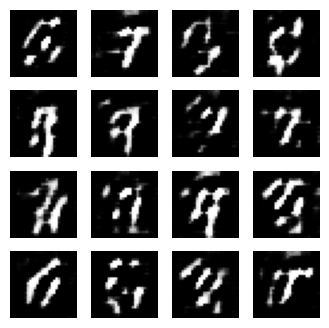

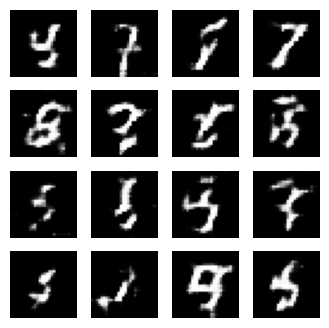

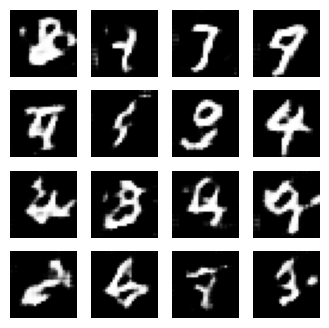

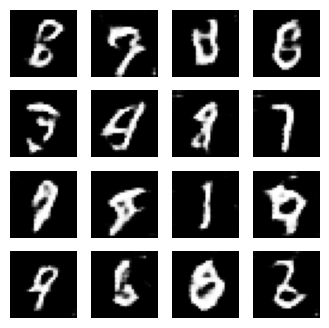

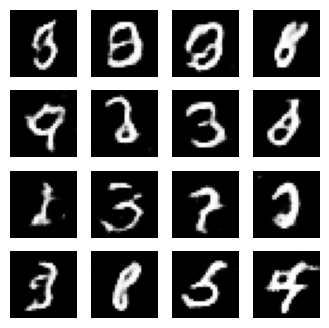

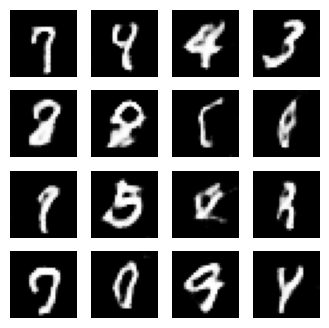

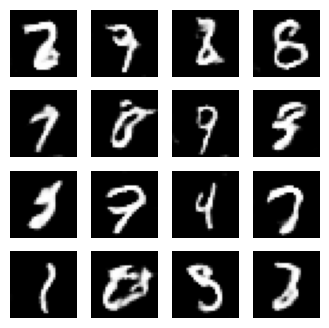

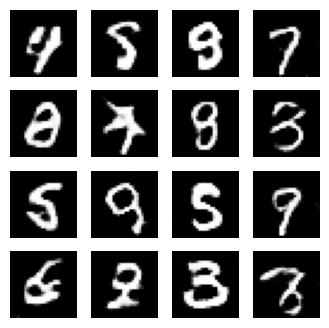

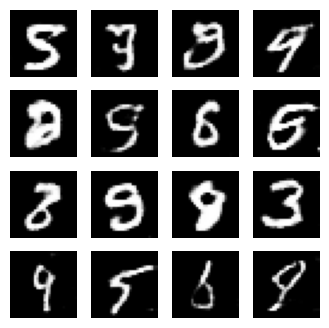

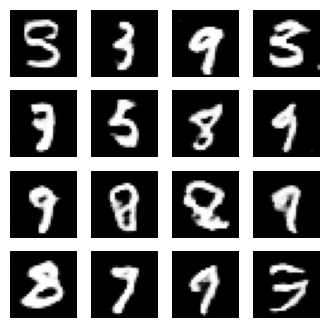

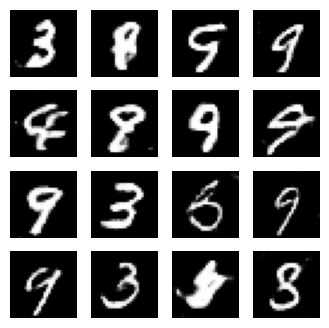

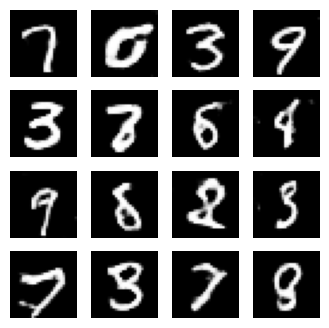

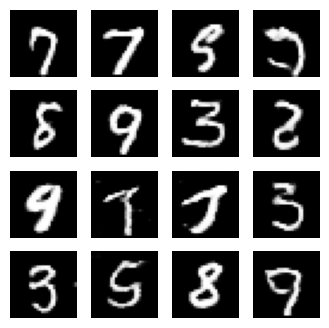

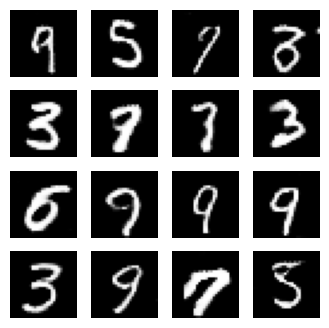

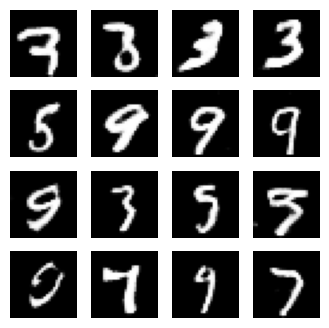

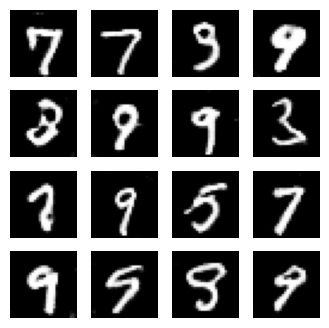

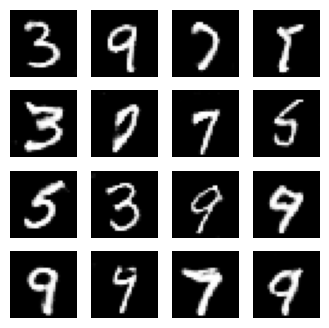

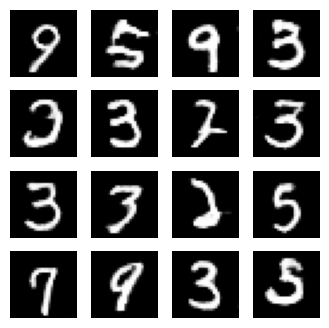

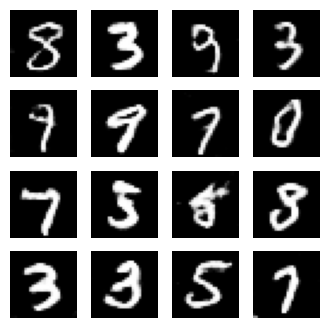

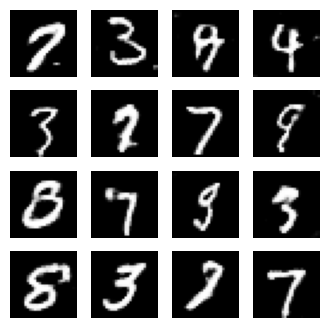

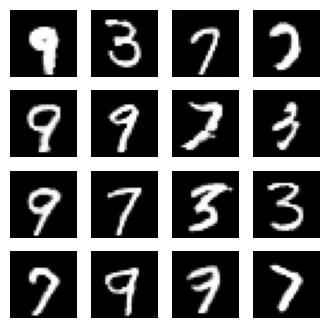

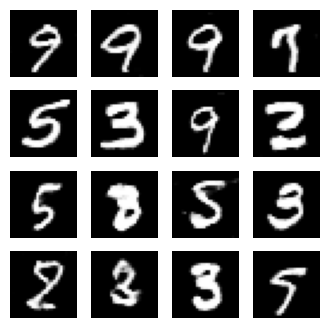

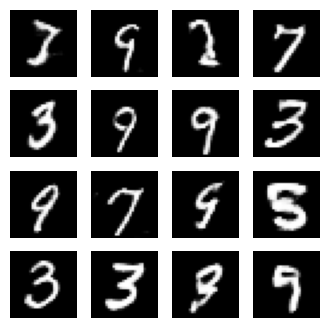

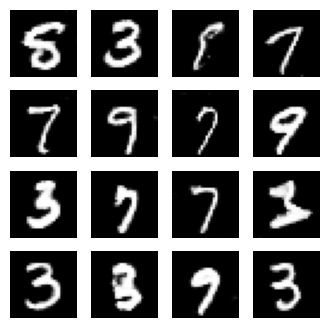

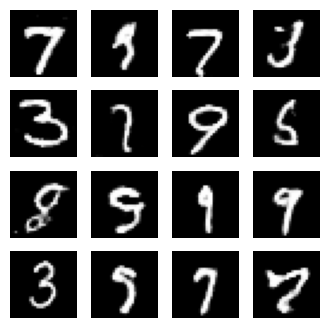

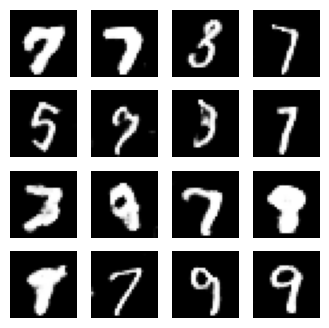

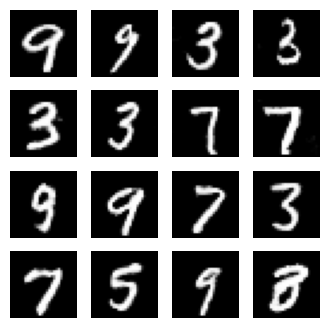

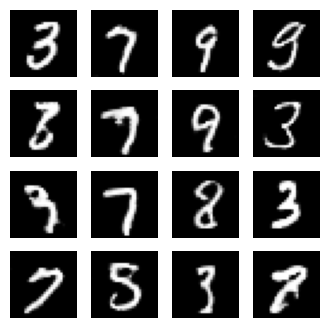

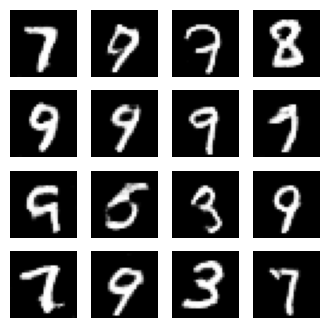

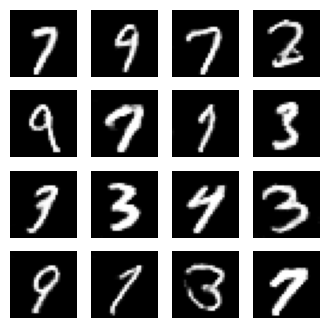

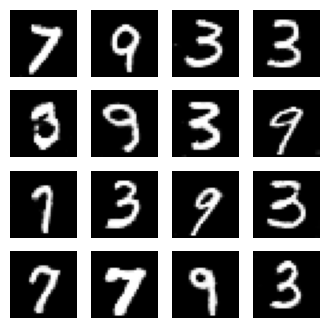

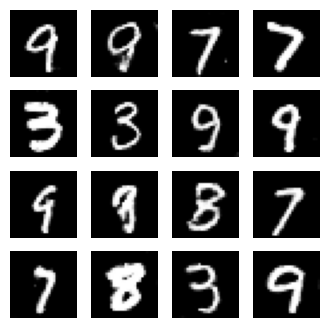

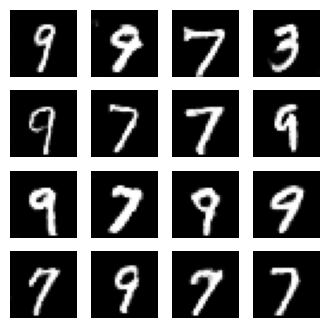

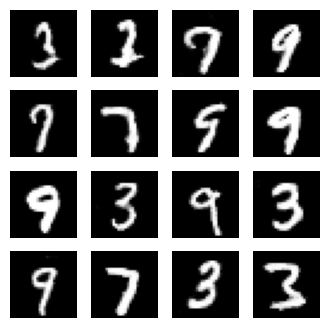

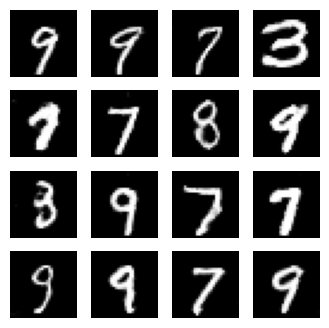

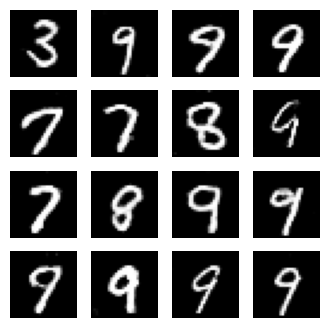

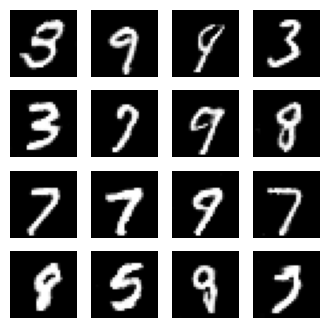

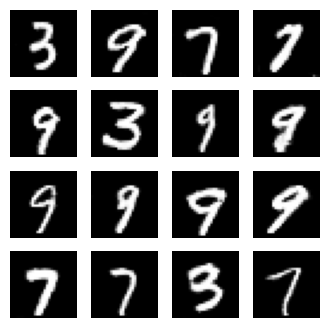

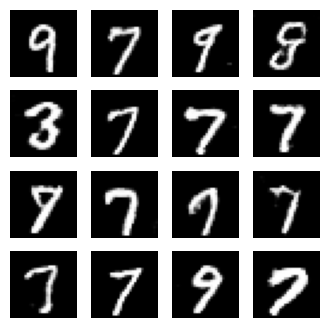

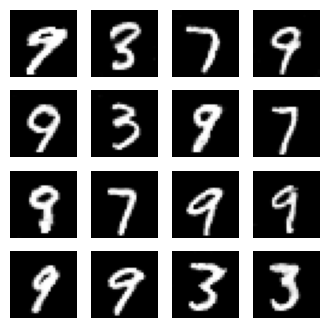

In [58]:
# Train
train(iterations, batch_size, sample_interval)

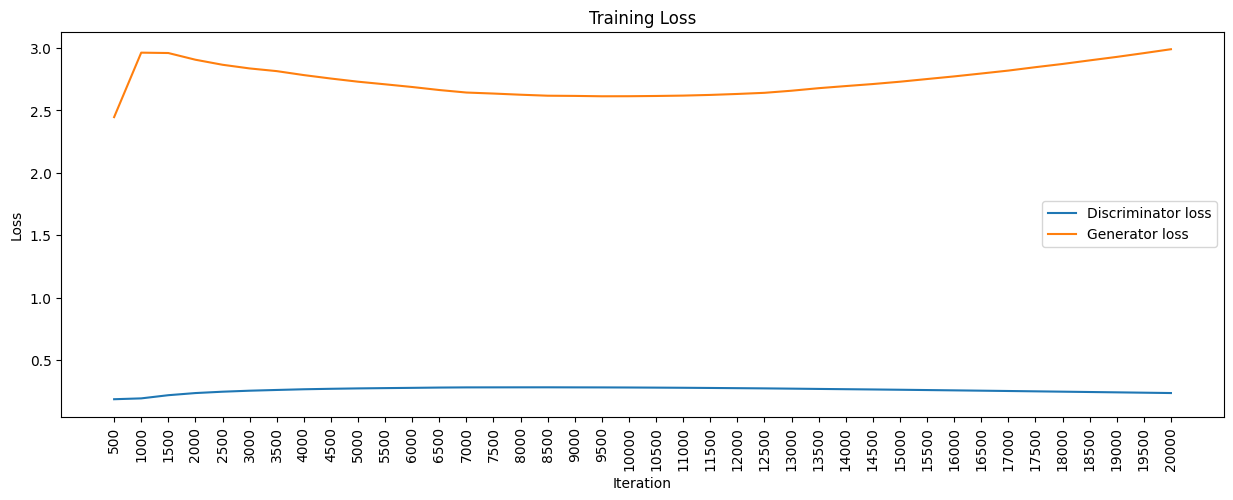

In [59]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iter_ckpt, losses.T[0], label="Discriminator loss")
plt.plot(iter_ckpt, losses.T[1], label="Generator loss")

plt.xticks(iter_ckpt, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()


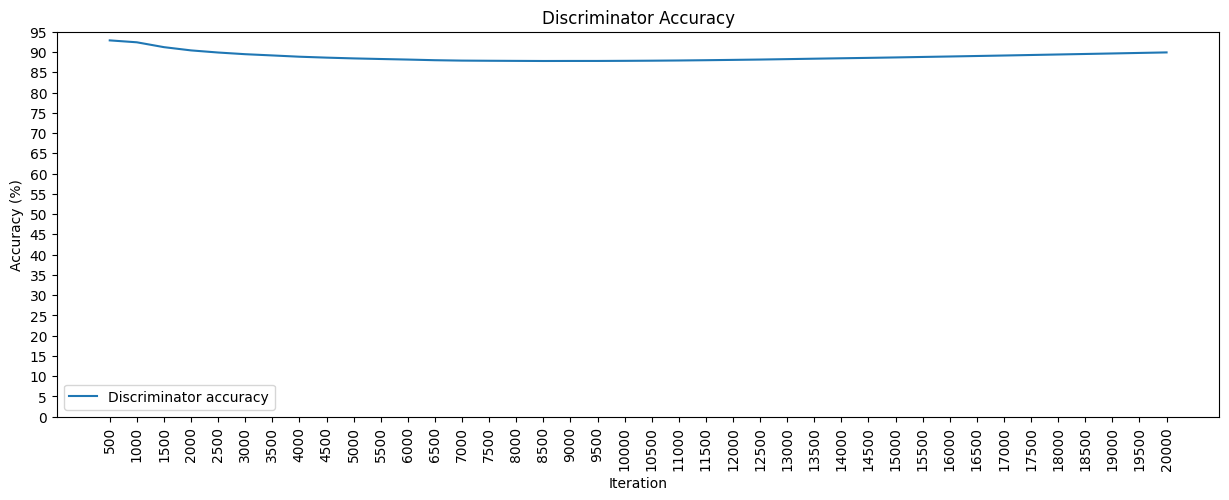

In [60]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iter_ckpt, accuracies, label="Discriminator accuracy")

plt.xticks(iter_ckpt, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()